# Data & Packages load


In [1]:
from utils import *

import numpy as np
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU
from tensorflow.keras.layers import Dense, Bidirectional, Dropout, Flatten
from tensorflow.keras import optimizers
from keras.utils import normalize, to_categorical
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

%matplotlib inline

In [2]:
# from preprocess_script import *

nonIa types:
SNTYPE 
II+IIP     58992
Ic+Ibc     15023
Ib         13993
IIL         7994
IIn+IIN     3998
Name: count, dtype: int64


c:\Users\aleja\anaconda3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:509: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


In [2]:
curves_path = "./curves_fitted.pkl"
curves_fitted = pd.read_pickle(curves_path)

In [3]:
curves_fitted

,Days,g,r,i,z,Type
0,"[-29.74899999999616, -28.497111111107287, -27....","[5.531199306097934, -3.8665451236341335, -9.09...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
1,"[-16.43000000000029, -15.089373737374013, -13....","[19.66315915828518, 31.6905338352687, 39.13073...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
2,"[-23.222999999998137, -22.023444444442568, -20...","[-1.7347892300340444, 5.4949069428988375, 12.2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
3,"[-27.98700000000099, -26.54528282828386, -25.1...","[4.715224926264313, 4.891896921441087, 1.83075...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
4,"[-25.65799999999581, -24.37505050504629, -23.0...","[-1.341309504711208, -8.943124259390503, -10.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
...,...,...,...,...,...,...
2974795,"[-27.437000000005355, -26.38815151515684, -25....","[8.29431358694477, 9.743137367500356, 11.04942...","[4.124846200513726, 3.808699694318282, 4.07861...","[1.1668327632622257, 2.39201266168775, 3.82135...","[6.622825994865473, 4.4936251672151615, 3.2323...",0
2974796,"[-20.702000000004773, -20.07566666667139, -19....","[0.810357591777264, 5.348349126525441, 9.40002...","[4.535688525721003, 6.558562805693516, 8.54960...","[-6.508471874768616, -6.654916301120153, -6.52...","[6.9051457940187015, 2.785024191660798, -0.499...",0
2974797,"[-26.980999999999767, -25.941101010100805, -24...","[-0.9271372489112032, 4.286748347100462, 9.317...","[-18.44563508369465, -10.038230355744448, -2.1...","[3.1026306328163757, 4.400256727234632, 6.4050...","[4.577443256576728, 7.884984235223436, 11.6322...",0
2974798,"[-18.83299999999872, -17.755727272726052, -16....","[13.005091536153763, 21.387326722432036, 28.81...","[4.947744232592987, 12.577419604493262, 19.619...","[7.846916643129147, 14.002644069901704, 19.117...","[16.105118013759974, 17.682175052209182, 19.56...",0


In [4]:
curves_RNN = curves_fitted[['Days', 'g ', 'r ', 'i ', 'z ']].to_numpy().tolist()
types = curves_fitted.Type.to_numpy()

curves_RNN = np.reshape(curves_RNN, (curves_fitted.index.size, 100, 5))
types = types.reshape((-1, 1))

X_train, X_test, y_train, y_test = train_test_split(curves_RNN, types,
                                                    train_size=0.7,
                                                    random_state=42)

In [5]:
n_obs, seq_len, feat = X_train.shape
X_train.shape

(2082359, 100, 5)

# Model: 1 layer & 1 neuron
---


## SimpleRNN

In [6]:
model_1l_1simpleRNN = Sequential()
model_1l_1simpleRNN.add(SimpleRNN(1, input_shape=(seq_len, feat),
                                  return_sequences=True, dropout=0.2))
model_1l_1simpleRNN.add(BatchNormalization())
model_1l_1simpleRNN.add(Flatten())
model_1l_1simpleRNN.add(Dense(1, activation='sigmoid'))

optimizer = optimizers.Adam()
model_1l_1simpleRNN.compile(loss='binary_crossentropy',
                            optimizer=optimizer,
                            metrics=['accuracy'])
model_1l_1simpleRNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 100, 1)            7         
                                                                 
 batch_normalization (BatchN  (None, 100, 1)           4         
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 112
Trainable params: 110
Non-trainable params: 2
_________________________________________________________________


In [7]:
history_1l_1simpleRNN = model_1l_1simpleRNN.fit(X_train, y_train,
                                                validation_data=(X_test, y_test),
                                                epochs=30, batch_size=128)
predict_1l_1simpleRNN = model_1l_1simpleRNN.predict(X_test)

Epoch 1/30
16269/16269 [==============================] - 136s 8ms/step - loss: 0.5897 - accuracy: 0.6717 - val_loss: 0.5747 - val_accuracy: 0.6822
Epoch 2/30
16269/16269 [==============================] - 124s 8ms/step - loss: 0.5776 - accuracy: 0.6805 - val_loss: 0.5756 - val_accuracy: 0.6777
Epoch 3/30
16269/16269 [==============================] - 123s 8ms/step - loss: 0.5773 - accuracy: 0.6802 - val_loss: 0.5738 - val_accuracy: 0.6821
Epoch 4/30
16269/16269 [==============================] - 122s 8ms/step - loss: 0.5772 - accuracy: 0.6807 - val_loss: 0.5738 - val_accuracy: 0.6821
Epoch 5/30
16269/16269 [==============================] - 123s 8ms/step - loss: 0.5770 - accuracy: 0.6810 - val_loss: 0.5739 - val_accuracy: 0.6836
Epoch 6/30
16269/16269 [==============================] - 122s 8ms/step - loss: 0.5771 - accuracy: 0.6808 - val_loss: 0.5736 - val_accuracy: 0.6841
Epoch 7/30
16269/16269 [==============================] - 147s 9ms/step - loss: 0.5769 - accuracy: 0.6811 - val_

<AxesSubplot:>

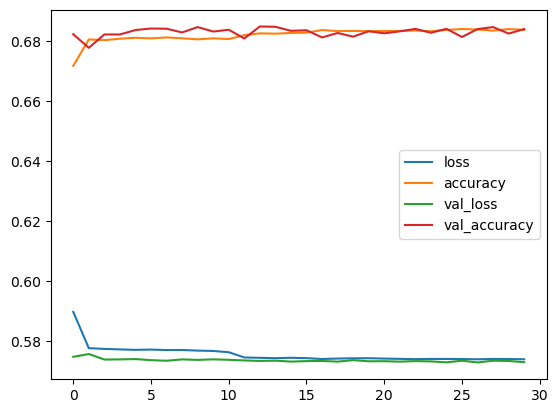

In [8]:
pd.DataFrame(history_1l_1simpleRNN.history).plot()

In [9]:
plot_confusion_matrix(y_test, predict_1l_1simpleRNN.round(), ['Ia', 'nonIa'], normalize=True)

MemoryError: Unable to allocate 6.81 MiB for an array with shape (892441,) and data type int64

AUC = 0.6839132161080075


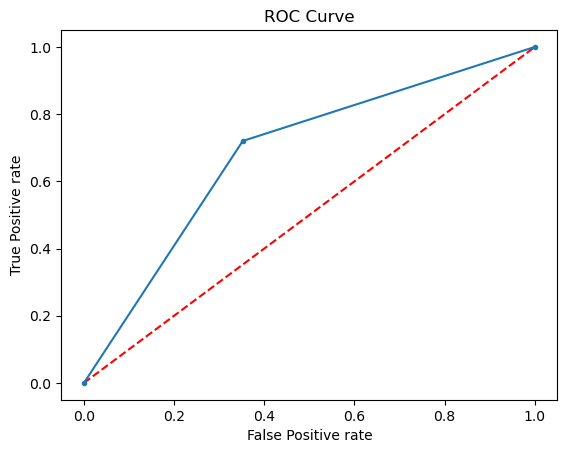

In [10]:
plot_roc_curve(y_test, predict_1l_1simpleRNN.round(), auc_print=True)

In [11]:
acc_1l_1simpleRNN = model_1l_1simpleRNN.evaluate(X_test, y_test, verbose=0)
print(f'accuracy: {acc_1l_1simpleRNN[1] * 100 : 0.2f}%')

MemoryError: Unable to allocate 1.66 GiB for an array with shape (892441, 100, 5) and data type float32

## LSTM

In [ ]:
model_1l_1LSTM = Sequential()
model_1l_1LSTM.add(LSTM(1, input_shape=(seq_len, feat),
                        return_sequences=True, dropout=0.2))
model_1l_1LSTM.add(BatchNormalization())
model_1l_1LSTM.add(Flatten())
model_1l_1LSTM.add(Dense(1, activation='sigmoid'))

optimizer = optimizers.Adam()
model_1l_1LSTM.compile(loss='binary_crossentropy',
                       optimizer=optimizer,
                       metrics=['accuracy'])
model_1l_1LSTM.summary()

In [ ]:
history_1l_1LSTM = model_1l_1LSTM.fit(X_train, y_train,
                                     validation_data=(X_test, y_test),
                                     epochs=30, batch_size=128)
predict_1l_1LSTM = model_1l_1LSTM.predict(X_test)

In [ ]:
pd.DataFrame(history_1l_1LSTM.history).plot()

In [ ]:
plot_confusion_matrix(y_test, predict_1l_1LSTM.round(), ['Ia', 'nonIa'], normalize=True)

In [ ]:
plot_roc_curve(y_test, predict_1l_1LSTM.round(), auc_print=True)

In [ ]:
acc_1l_1LSTM = model_1l_1LSTM.evaluate(X_test, y_test, verbose=0)
print(f'accuracy: {acc_1l_1LSTM[1] * 100 : 0.2f}%')

## GRU

In [ ]:
model_1l_1GRU = Sequential()
model_1l_1GRU.add(GRU(1, input_shape=(seq_len, feat),
                      return_sequences=True, dropout=0.2))
model_1l_1GRU.add(BatchNormalization())
model_1l_1GRU.add(Flatten())
model_1l_1GRU.add(Dense(1, activation='sigmoid'))

optimizer = optimizers.Adam()
model_1l_1GRU.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
model_1l_1GRU.summary()

In [ ]:
history_1l_1GRU = model_1l_1GRU.fit(X_train, y_train,
                                   validation_data=(X_test, y_test),
                                   epochs=30, batch_size=128)
predict_1l_1GRU = model_1l_1GRU.predict(X_test)

In [ ]:
pd.DataFrame(history_1l_1GRU.history).plot()

In [ ]:
plot_confusion_matrix(y_test, predict_1l_1GRU.round(), ['Ia', 'nonIa'], normalize=True)

In [ ]:
plot_roc_curve(y_test, predict_1l_1GRU.round(), auc_print=True)

In [ ]:
acc_1l_1GRU = model_1l_1GRU.evaluate(X_test, y_test, verbose=0)
print(f'accuracy: {acc_1l_1GRU[1] * 100 : 0.2f}%')

## Results

- SimpleRNN: slow train
- LSTM & GRU: accurate considering only 1 neuron
  - LSTM:
    - 98% Ia - 94% NonIa 
    - work better with default _lr_ ~_lr = 1e-3_~
  - GRU:
    - 94% Ia - 88% NonIa 
    - work better with default _lr_ ~_lr = 5e-4_~

# Model: 1 bidirectional layer & 1 neuron
---

## LSTM

In [ ]:
model_1bl_1LSTM = Sequential()
model_1bl_1LSTM.add(Bidirectional(LSTM(1, return_sequences=True, dropout=0.2),
                                  input_shape=(seq_len, feat)))
model_1bl_1LSTM.add(BatchNormalization())
model_1bl_1LSTM.add(Flatten())
model_1bl_1LSTM.add(Dense(1, activation='sigmoid'))

optimizer = optimizers.Adam()
model_1bl_1LSTM.compile(loss='binary_crossentropy',
                       optimizer=optimizer,
                       metrics=['accuracy'])
model_1bl_1LSTM.summary()

In [ ]:
history_1bl_1LSTM = model_1bl_1LSTM.fit(X_train, y_train,
                                     validation_data=(X_test, y_test),
                                     epochs=30, batch_size=128)
predict_1bl_1LSTM = model_1bl_1LSTM.predict(X_test)

In [ ]:
pd.DataFrame(history_1bl_1LSTM.history).plot()

In [ ]:
plot_confusion_matrix(y_test, predict_1bl_1LSTM.round(), ['Ia', 'nonIa'], normalize=True)

In [ ]:
plot_roc_curve(y_test, predict_1bl_1LSTM.round(), auc_print=True)

In [ ]:
acc_1bl_1LSTM = model_1bl_1LSTM.evaluate(X_test, y_test, verbose=0)
print(f'accuracy: {acc_1bl_1LSTM[1] * 100 : 0.2f}%')

## GRU

In [ ]:
model_1bl_1GRU = Sequential()
model_1bl_1GRU.add(Bidirectional(GRU(1, return_sequences=True, dropout=0.2),
                                 input_shape=(seq_len, feat)))
model_1bl_1GRU.add(BatchNormalization())
model_1bl_1GRU.add(Flatten())
model_1bl_1GRU.add(Dense(1, activation='sigmoid'))

optimizer = optimizers.Adam()
model_1bl_1GRU.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
model_1bl_1GRU.summary()

In [ ]:
history_1bl_1GRU = model_1bl_1GRU.fit(X_train, y_train,
                                      validation_data=(X_test, y_test),
                                      epochs=30, batch_size=128)
predict_1bl_1GRU = model_1bl_1GRU.predict(X_test)

In [ ]:
pd.DataFrame(history_1bl_1GRU.history).plot()

In [ ]:
plot_confusion_matrix(y_test, predict_1bl_1GRU.round(), ['Ia', 'nonIa'], normalize=True)

In [ ]:
plot_roc_curve(y_test, predict_1bl_1GRU.round(), auc_print=True)

In [ ]:
acc_1bl_1GRU = model_1bl_1GRU.evaluate(X_test, y_test, verbose=0)
print(f'accuracy: {acc_1bl_1GRU[1] * 100 : 0.2f}%')

## Results

- LSTM & GRU: accuracy improve using bidirectional layer

  - LSTM: 94% Ia - 98% NonIa
  - GRU: 98% Ia - 94% NonIa

# Model: 1 bidirectional layer & 4 neurons
---

## LSTM 


In [ ]:
model_1bl_4LSTM = Sequential()
model_1bl_4LSTM.add(Bidirectional(LSTM(4, return_sequences=True, dropout=0.2),
                                  input_shape=(seq_len, feat)))
model_1bl_4LSTM.add(BatchNormalization())
model_1bl_4LSTM.add(Flatten())
model_1bl_4LSTM.add(Dense(1, activation='sigmoid'))

optimizer = optimizers.Adam()
model_1bl_4LSTM.compile(loss='binary_crossentropy',
                       optimizer=optimizer,
                       metrics=['accuracy'])
model_1bl_4LSTM.summary()

In [ ]:
history_1bl_4LSTM = model_1bl_4LSTM.fit(X_train, y_train,
                                     validation_data=(X_test, y_test),
                                     epochs=30, batch_size=128)
predict_1bl_4LSTM = model_1bl_4LSTM.predict(X_test)

In [ ]:
pd.DataFrame(history_1bl_4LSTM.history).plot()

In [ ]:
plot_confusion_matrix(y_test, predict_1bl_4LSTM.round(), ['Ia', 'nonIa'], normalize=True)

In [ ]:
plot_roc_curve(y_test, predict_1bl_4LSTM.round(), auc_print=True)

In [ ]:
acc_1bl_4LSTM = model_1bl_4LSTM.evaluate(X_test, y_test, verbose=0)
print(f'accuracy: {acc_1bl_4LSTM[1] * 100 : 0.2f}%')

## GRU

In [ ]:
model_1bl_4GRU = Sequential()
model_1bl_4GRU.add(Bidirectional(GRU(4, return_sequences=True, dropout=0.2),
                                 input_shape=(seq_len, feat)))
model_1bl_4GRU.add(BatchNormalization())
model_1bl_4GRU.add(Flatten())
model_1bl_4GRU.add(Dense(1, activation='sigmoid'))

optimizer = optimizers.Adam()
model_1bl_4GRU.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
model_1bl_4GRU.summary()

In [ ]:
history_1bl_4GRU = model_1bl_4GRU.fit(X_train, y_train,
                                      validation_data=(X_test, y_test),
                                      epochs=30, batch_size=128)
predict_1bl_4GRU = model_1bl_4GRU.predict(X_test)

In [ ]:
pd.DataFrame(history_1bl_4GRU.history).plot()

In [ ]:
plot_confusion_matrix(y_test, predict_1bl_4GRU.round(), ['Ia', 'nonIa'], normalize=True)

In [ ]:
plot_roc_curve(y_test, predict_1bl_4GRU.round(), auc_print=True)

In [ ]:
acc_1bl_4GRU = model_1bl_4GRU.evaluate(X_test, y_test, verbose=0)
print(f'accuracy: {acc_1bl_4GRU[1] * 100 : 0.2f}%')

# Model: 1 bidirectional layer & 64 neurons
---

## LSTM

In [ ]:
model_1bl_64LSTM = Sequential()
model_1bl_64LSTM.add(Bidirectional(LSTM(64, return_sequences=True, dropout=0.2),
                                   input_shape=(seq_len, feat)))
model_1bl_64LSTM.add(BatchNormalization())
model_1bl_64LSTM.add(Flatten())
model_1bl_64LSTM.add(Dense(1, activation='sigmoid'))

optimizer = optimizers.Adam()
model_1bl_64LSTM.compile(loss='binary_crossentropy',
                       optimizer=optimizer,
                       metrics=['accuracy'])
model_1bl_64LSTM.summary()

In [ ]:
history_1bl_64LSTM = model_1bl_64LSTM.fit(X_train, y_train,
                                          validation_data=(X_test, y_test),
                                          epochs=30, batch_size=128)
predict_1bl_64LSTM = model_1bl_64LSTM.predict(X_test)

In [ ]:
pd.DataFrame(history_1bl_64LSTM.history).plot()

In [ ]:
plot_confusion_matrix(y_test, predict_1bl_64LSTM.round(), ['Ia', 'nonIa'], normalize=True)

In [ ]:
plot_roc_curve(y_test, predict_1bl_64LSTM.round(), auc_print=True)

In [ ]:
acc_1bl_64LSTM = model_1bl_64LSTM.evaluate(X_test, y_test, verbose=0)
print(f'accuracy: {acc_1bl_64LSTM[1] * 100 : 0.2f}%')

## GRU

In [ ]:
model_1bl_64GRU = Sequential()
model_1bl_64GRU.add(Bidirectional(GRU(64, return_sequences=True, dropout=0.2),
                                  input_shape=(seq_len, feat)))
model_1bl_64GRU.add(BatchNormalization())
model_1bl_64GRU.add(Flatten())
model_1bl_64GRU.add(Dense(1, activation='sigmoid'))

optimizer = optimizers.Adam()
model_1bl_64GRU.compile(loss='binary_crossentropy',
                        optimizer=optimizer,
                        metrics=['accuracy'])
model_1bl_64GRU.summary()

In [ ]:
history_1bl_64GRU = model_1bl_64GRU.fit(X_train, y_train,
                                        validation_data=(X_test, y_test),
                                        epochs=30, batch_size=128)
predict_1bl_64GRU = model_1bl_64GRU.predict(X_test)

In [ ]:
pd.DataFrame(history_1bl_64GRU.history).plot()

In [ ]:
plot_confusion_matrix(y_test, predict_1bl_64GRU.round(), ['Ia', 'nonIa'], normalize=True)

In [ ]:
plot_roc_curve(y_test, predict_1bl_64GRU.round(), auc_print=True)

In [ ]:
acc_1bl_64GRU = model_1bl_64GRU.evaluate(X_test, y_test, verbose=0)
print(f'accuracy: {acc_1bl_64GRU[1] * 100 : 0.2f}%')

# Model: 2 bidirectional layer & 4 neurons
---
- 2 per layer

## LSTM

In [ ]:
model_2bl_4LSTM = Sequential()
model_2bl_4LSTM.add(Bidirectional(LSTM(2, return_sequences=True, dropout=0.2),
                                  input_shape=(seq_len, feat)))
model_2bl_4LSTM.add(BatchNormalization())

model_2bl_4LSTM.add(Bidirectional(LSTM(2, return_sequences=True, dropout=0.2),
                                  input_shape=(seq_len, feat)))
model_2bl_4LSTM.add(Flatten())
model_2bl_4LSTM.add(Dense(1, activation='sigmoid'))

optimizer = optimizers.Adam()
model_2bl_4LSTM.compile(loss='binary_crossentropy',
                       optimizer=optimizer,
                       metrics=['accuracy'])
model_2bl_4LSTM.summary()

In [ ]:
history_2bl_4LSTM = model_2bl_4LSTM.fit(X_train, y_train,
                                      validation_data=(X_test, y_test),
                                      epochs=30, batch_size=128)
predict_2bl_4LSTM = model_2bl_4LSTM.predict(X_test)

In [ ]:
pd.DataFrame(history_2bl_4LSTM.history).plot()

In [ ]:
plot_confusion_matrix(y_test, predict_2bl_4LSTM.round(), ['Ia', 'nonIa'], normalize=True)

In [ ]:
plot_roc_curve(y_test, predict_2bl_4LSTM.round(), auc_print=True)

In [ ]:
acc_2bl_4LSTM = model_2bl_4LSTM.evaluate(X_test, y_test, verbose=0)
print(f'accuracy: {acc_2bll_4LSTM[1] * 100 : 0.2f}%')

## GRU

In [ ]:
model_2bl_4GRU= Sequential()
model_2bl_4GRU.add(Bidirectional(GRU(2, return_sequences=True, dropout=0.2),
                                 input_shape=(seq_len, feat)))
model_2bl_4GRU.add(BatchNormalization())

model_2bl_4GRU.add(Bidirectional(GRU(2, return_sequences=True, dropout=0.2),
                                 input_shape=(seq_len, feat)))
model_2bl_4GRU.add(Flatten())
model_2bl_4GRU.add(Dense(1, activation='sigmoid'))

optimizer = optimizers.Adam()
model_2bl_4GRU.compile(loss='binary_crossentropy',
                       optimizer=optimizer,
                       metrics=['accuracy'])
model_2bl_4GRU.summary()

In [ ]:
history_2bl_4GRU= model_2bl_4GRU.fit(X_train, y_train,
                                     validation_data=(X_test, y_test),
                                     epochs=30, batch_size=128)
predict_2bl_4GRU = model_2bl_4GRU.predict(X_test)

In [ ]:
pd.DataFrame(history_2bl_4GRU.history).plot()

In [ ]:
plot_confusion_matrix(y_test, predict_2bl_4GRU.round(), ['Ia', 'nonIa'], normalize=True)

In [ ]:
plot_roc_curve(y_test, predict_2bl_4GRU.round(), auc_print=True)

In [ ]:
acc_2bl_4GRU = model_2bl_4GRU.evaluate(X_test, y_test, verbose=0)
print(f'accuracy: {acc_2bl_4GRU[1] * 100 : 0.2f}%')